# 1. Backpropogation

We will study the backpropagation behavior for an exponential neuron, given by:

$$
f(z) = e^{2z}-1
$$

Consider a two-dimensional input given by $x = (x_1, x_2)^T$. A weight vector $w = (w_1, w_2)^T$ and a bias $b$ act on it. Thus, the output of a neuron is given by $f(x_1, x_2) = e^{2(w_1x_1+w_2x_2+b)}-1$.
\
\
(a.) Draw the computational graph for the neuron in terms of elementary operations (addition, subtraction, multiplication, division, exponentiation) as seen in class. **[2 points]**

(b.) Consider inputs $x_1 = 0.4, x_2=0.5,$ weights $w_1 = 0.2, w_2 = 0.3$ and bias $b = 0.1$. In the same figure, show the values at each node of the graph during forward propagation. **[2 points]**

(c.) Use backpropagation to determine the gradients $\frac{\partial f}{\partial w_1}, \frac{\partial f}{\partial w_2}, \frac{\partial f}{\partial b}$. Also illustrate in the same figure the intermediate gradients at each node of the computation graph. **[4 points]**

(d.) Explain the process of backpropagation you used to compute partial derivatives. **[2 points]**

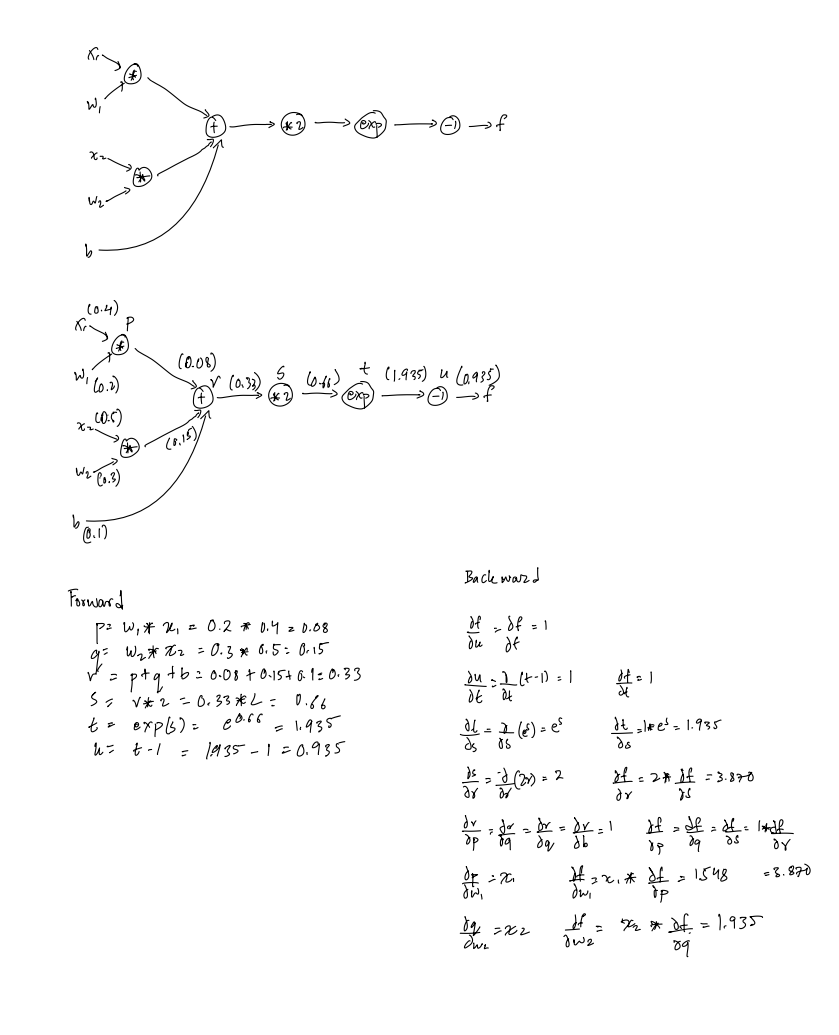

In [1]:
from IPython.display import Image
Image(filename="/content/ssss.png")

# 2. Training a small CNN for MNIST digit classification

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

In [1]:
!pip install wandb
import wandb
wandb.init()

wandb: Currently logged in as: skatel (skatel-uc-san-diego). Use `wandb login --relogin` to force relogin


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import torch.autograd as Variable

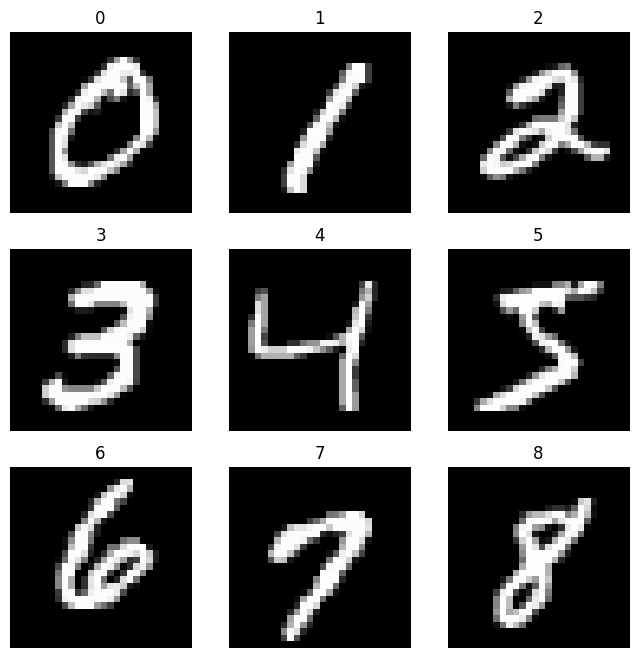

Image Shape: torch.Size([1, 28, 28])


In [4]:
# Load in the datasets

# Download the MNIST Datasets (you will use these variables later on)
MNIST_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

MNIST_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Code adapted from PyTorch https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
train_labels = MNIST_train.targets
label = (train_labels == 0).nonzero()
for i in range(1, cols * rows + 1):
    # Select image of each label
    indices = (train_labels == i-1).nonzero()
    sample_idx = indices[0,0]
    img, label = MNIST_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(i-1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f"Image Shape: {img.shape}")

In [5]:
# Check device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cpu device


**[ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [6]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        # --------------- YOUR CODE HERE ---------------
        # DEFINE THE NETWORK STRUCTURE

        # Example: self.conv1 = nn.Conv2d(1, 3, 5,stride=1,padding=2,bias=True)
        # You can look at the main PyTorch tutorial for reference
        # https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

        self.conv1 = nn.Conv2d(1, 32, 5,stride=1,padding=2,bias=True)
        self.maxpool1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(32, 64, 5,stride=1,padding=2,bias=True)
        self.maxpool2 = nn.MaxPool2d(2,stride=2)
        self.fully_connected1 = nn.Linear(3136, 1024)
        if drop:
            self.dropout = nn.Dropout(p=0.4)
        else:
            self.dropout = None
        self.fully_connected2 = nn.Linear(1024, 10)


    def forward(self, x):
        # --------------- YOUR CODE HERE ---------------
        # Example: x = self.conv1(x)
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = F.relu(self.fully_connected1(x.view(-1,3136)))
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.fully_connected2(x)

        return x

# Print net
net = Net(drop=True).to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fully_connected1): Linear(in_features=3136, out_features=1024, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fully_connected2): Linear(in_features=1024, out_features=10, bias=True)
)


**[ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**

* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on training set on the same plot
* Print the accuracy on test set after training

Test accuracies are expected to be quite high (~98 %) for all networks.

Training can take a few minutes.

In [7]:
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# 'to_train' is a parameter that determines what part of the net to train.
# It is not required for this question, but will be useful in the next one.
# You should also change the parameters: epochs, batch, and learning rate as necessary.
# You may need to tune these hyperparameters.
def train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
    # Initialize loss
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]

    # Create dataloader
    MNIST_train_dataloader = DataLoader(train_dataset, batch_size=batch)

    # Select optimizer
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
    optimizer.zero_grad()

    # Set model to training mode
    net.train()
    for k in tqdm(range(epochs)):
        for it, (X,y) in enumerate(MNIST_train_dataloader):
            # Send to device
            X, y = X.to(device), y.to(device)

            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays
            # --------------- YOUR CODE HERE ---------------

            # Example: pred = net(X)
            pred = net(X)
            loss = criterion(pred,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losslist.append(loss.item())
            acclist.append((pred.argmax(1) == y).type(torch.float).sum().item()/len(y))

    return losslist,acclist

# Used to test or evaluate your network
def test(test_dataset, net):
    batch = 200
    test_dataloader = DataLoader(test_dataset, batch_size=batch)
    size = len(test_dataloader.dataset)

    # Set model to eval mode
    net.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            # Send to device
            X, y = X.to(device), y.to(device)

            # Prediction
            pred = net(X)

            # Calculate number of correct predictions in the batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute total accuracy
    acc = correct / size
    return acc


100%|██████████| 10/10 [35:10<00:00, 211.01s/it]


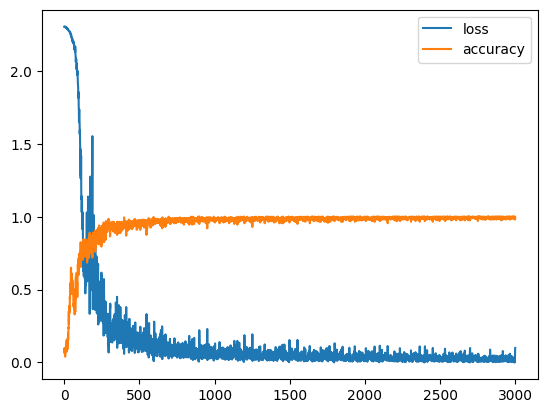

Accuracy:0.9894


In [8]:
# SGD with no dropout
# Example code
net = Net(drop=False).to(device)
loss1, acc1 = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss1))
plt.plot(ax, loss1, ax, acc1)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

In [9]:
# SGD with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss2, acc2 = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss2))
plt.plot(ax, loss2, ax, acc2)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))


  0%|          | 0/10 [02:33<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Adam with no dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=False).to(device)
loss3, acc3 = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss3))
plt.plot(ax, loss3, ax, acc3)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

In [ ]:
# Adam with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss4, acc4 = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss4))
plt.plot(ax, loss4, ax, acc4)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

**[ 5 points ] Plot the following graphs and comment on them**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot
* Training loss graphs for Adam-dropout for 3 different values of batch size such that there is some difference in the graphs, on the same plot

In [10]:
# --------------- YOUR CODE HERE ---------------
ax=range(len(loss1))
plt.plot(ax, loss1, ax, loss2, ax, loss3, ax, loss4)
plt.legend(['SGD no dropout', 'SGD dropout', 'Adam no dropout', 'Adam dropout'])
plt.show()

ax=range(len(acc1))
plt.plot(ax, acc1, ax, acc2, ax, acc3, ax, acc4)
plt.legend(['SGD no dropout', 'SGD dropout', 'Adam no dropout', 'Adam dropout'])
plt.show()



# # Train the loss graphs for Adam dropout for 3 different values of batch size such there is some difference in the graphs, on the same plot.

# net = Net(drop=True).to(device)
# loss5, acc5 = train(MNIST_train, net, net.parameters(), 'adam', batch=100)
# loss6, acc6 = train(MNIST_train, net, net.parameters(), 'adam', batch=200)
# loss7, acc7 = train(MNIST_train, net, net.parameters(), 'adam', batch=300)
# ax=range(len(loss7))
# plt.plot(ax, loss5, ax, loss6, ax, loss7)
# plt.legend(['batch=100', 'batch=200', 'batch=300'])
# plt.show()
# ax=range(len(acc7))
# plt.plot(ax, acc5, ax, acc6, ax, acc7)
# plt.legend(['batch=100', 'batch=200', 'batch=300'])
# plt.show()


net = Net(drop=True).to(device)
loss100, acc100 = train(MNIST_train, net, net.parameters(), 'adam', batch = 100)
net = Net(drop=True).to(device)
loss300, acc300 = train(MNIST_train, net, net.parameters(), 'adam', batch = 300)
net = Net(drop=True).to(device)
loss1000, acc1000 = train(MNIST_train, net, net.parameters(), 'adam', batch = 1000)

ax=range(len(loss1000))
plt.plot(ax,loss100[:len(loss1000)],ax,loss300[:len(loss1000)],ax,loss1000)
plt.legend(['Batch Size: 100','Batch Size: 300','Batch Size:1000'])
plt.show()

NameError: name 'loss2' is not defined

**[ 2 points ] Choose one of the hyperparameters in the train function (examples: learning rate, momentum). Train three models using the same optimizer and using dropout/no dropout for all with different values for the hyperparameter you've chosen. Plot the training loss graphs for the three models on the same plot. Make sure that you change the hyperparameter enough such that there is a clear difference in the graphs and comment on the differences.**

In [ ]:
# # --------------- YOUR CODE HERE ---------------
# net = Net(drop=True).to(device)
# x1, y1 = train(MNIST_train, net, net.parameters(), 'adam', epochs=100)
# net = Net(drop=True).to(device)
# x2, y2 = train(MNIST_train, net, net.parameters(), 'adam', epochs=300)
# net = Net(drop=True).to(device)
# x3, y3 = train(MNIST_train, net, net.parameters(), 'adam', epochs=600)

# ax = range(len(x1))
# plt.plot(ax, x1, ax, x2, ax, x3)
# plt.legend(['100 epochs', '300 epochs', '600 epochs'])
# plt.show()
# ax = range(len(y1))
# plt.plot(ax, y1, ax, y2, ax, y3)
# plt.legend(['100 epochs', '300 epochs', '600 epochs'])
# plt.show()

net = Net(drop=True).to(device)
loss8, acc8 = train(MNIST_train, net, net.parameters(), 'adam', learning_rate=1e-2)
net = Net(drop=True).to(device)
loss9, acc9 = train(MNIST_train, net, net.parameters(), 'adam', learning_rate=1e-3)
net = Net(drop=True).to(device)
loss10, acc10 = train(MNIST_train, net, net.parameters(), 'adam', learning_rate=1e-4)

In [ ]:
ax=range(len(loss10))
plt.plot(ax, loss8, ax, loss9, ax, loss10)
plt.legend(['lr=1e-3', 'lr=1e-4', 'lr=1e-5'])
plt.show()
ax=range(len(acc10))
plt.plot(ax, acc8, ax, acc9, ax, acc10)
plt.legend(['lr=1e-3', 'lr=1e-4', 'lr=1e-5'])
plt.show()


# 3. Transfer learning

You will now visualize the effects of transfer learning by performing experiments using the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks

In [ ]:
# Downloading the dataset
!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

/content/CIFAR-10
--2023-12-06 03:12:48--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  56.6MB/s    in 2.9s    

2023-12-06 03:12:51 (56.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


In [ ]:
# DATA PARSING
path='./CIFAR-10/cifar-10-batches-py/'
data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)
# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9
print(f"Data Shape: {data.shape}")

Data Shape: (50000, 32, 32, 3)


 **[ 2 points ] Plot 3 random images corresponding to each label from the training data**


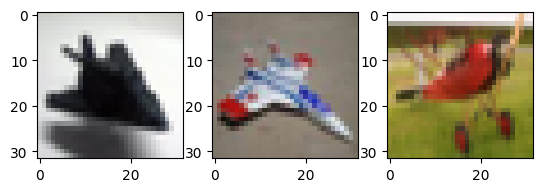

In [ ]:
# --------------- YOUR CODE HERE ---------------
for i in range(1):
    temp=data[labels==i]
    for j in range(3):
        plt.subplot(1,3,j+1)
        plt.imshow(temp[j])
    plt.show()

In [ ]:
# Split the data and labels into 2 sets, first one containing labels 0 to 4, and second one from 5 to 9.

data1=np.zeros((0,32,32,3))
labels1=[]
data2=np.zeros((0,32,32,3))
labels2=[]
for i in range(5):
    x=data[labels==i]
    data1=np.vstack((data1,x))
    labels1+=[i]*len(x)
for i in range(5,10):
    x=data[labels==i]
    data2=np.vstack((data2,x))
    labels2+=[i-5]*len(x)

labels1=np.array(labels1)
labels2=np.array(labels2)

torch_data1=data1.transpose((0,3,1,2)) # Switching order of dims to (N, C, H, W)
torch_data2=data2.transpose((0,3,1,2)) # Switching order of dims to (N, C, H, W)
torch_data1.shape, torch_data2.shape, labels1.shape, labels2.shape

((25000, 3, 32, 32), (25000, 3, 32, 32), (25000,), (25000,))

**[ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**

1. Layer 1 - Convolutional layer with kernel size 4, Stride 2, Output channels 5, Relu activation
2. Layer 2 - Convolutional layer with kernel size 4, Stride 1, Output channels 10, Relu avtication
3. Layer 3 - Convolutional layer with kernel size 4, Stride 1, Output channels 20, Relu activation
4. Layer 4 - Convolutional layer with kernel size 4, Stride 1, Output channels 40, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [ ]:
n=5
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, n, 4,stride=2,bias=True)
        self.conv2 = nn.Conv2d(n, 2*n, 4,stride=1,bias=True)
        self.conv3 = nn.Conv2d(2*n, 4*n, 4,stride=1,bias=True)
        self.conv4 = nn.Conv2d(4*n, 8*n, 4,stride=1,bias=True)
        self.fc=nn.Linear(6*6*8*n,5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.fc(x.reshape(-1,6*6*8*n))
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=1440, out_features=5, bias=True)
)


**[ 5 points ] Complete the train function below and follow the instructions**

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 55 %.

In [ ]:
# # to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
# def train(tdata,tlabel,net,to_train):
#     criterion = nn.CrossEntropyLoss()
#     losslist = []
#     acc=[]
#     epochs=10
#     batch=500
#     learning_rate=1e-3
#     optimizer = optim.Adam(to_train,lr=learning_rate)
#     for k in tqdm(range(epochs)):
#         for l in range(int(len(tdata)/batch)):
#             inds=np.random.randint(0,len(tdata)-1,batch)
#             inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
#             targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
#             optimizer.zero_grad()
#             prediction = net(inputs)
#             loss = criterion(prediction, targets)
#             loss.backward()
#             optimizer.step()
#             losslist.append(loss.data.cpu().numpy())
#             acc.append(np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds]))

#     return losslist,acc


def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist = [] # Hint: use argmax to find the index with the largest value
        # YOU MAY NEED TO CHANGE THESE PARAMETERS TO IMPROVE ACCURACY
    epochs = 20
    batch = 200
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    optimizer.zero_grad()

    for k in tqdm(range(epochs)):
      for l in range(int(len(tdata)/batch)):
        inds=np.random.randint(0,len(tdata)-1,batch)
        inputs = torch.FloatTensor(tdata[inds]).to(device)
        inputs.requires_grad_()
        targets = torch.LongTensor(tlabel[inds]).to(device)
        # --------------- YOUR CODE HERE ---------------
        optimizer.zero_grad()
        prediction = net(inputs)
        loss = criterion(prediction, targets)
        loss.backward()
        optimizer.step()
        losslist.append(loss.data.cpu().numpy())
        acclist.append(np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds]))
    return losslist, acclist

100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


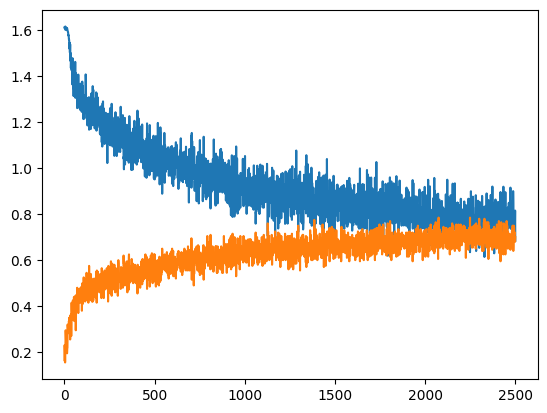

0.68454415
0.7


In [ ]:
# --------------- YOUR CODE HERE ---------------
# Initialize net
net = Net().to(device)
x1,a1=train(torch_data1,labels1,net,net.parameters())
ax=range(len(x1))
plt.plot(ax,x1,ax,a1)
plt.show()
print(x1[-1])
print(a1[-1])

**[ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)**

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


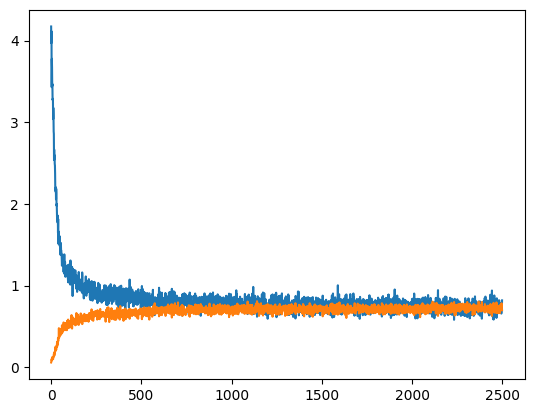

0.8200476
0.7


In [ ]:
# --------------- YOUR CODE HERE ---------------
x2,a2=train(torch_data2,labels2,net,net.fc.parameters())
ax=range(len(x2))
plt.plot(ax,x2,ax,a2)
plt.show()
print(x2[-1])
print(a2[-1])

**[ 3 points ] Now repeat the process in the opposite order**

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


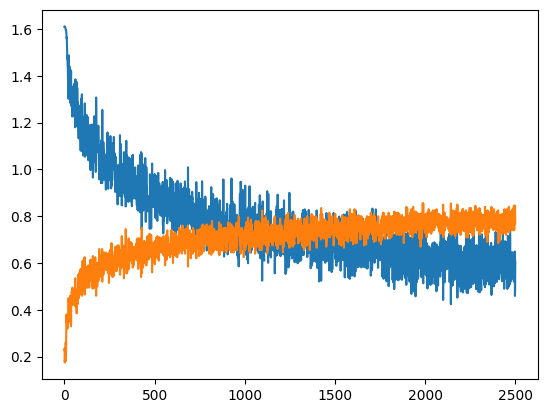

0.60684097
0.77


In [ ]:
# --------------- YOUR CODE HERE ---------------
# Initialize net
net = Net().cuda()
x3,a3=train(torch_data2,labels2,net,net.parameters())
ax=range(len(x3))
plt.plot(ax,x3,ax,a3)
plt.show()
print(x3[-1])
print(a3[-1])

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


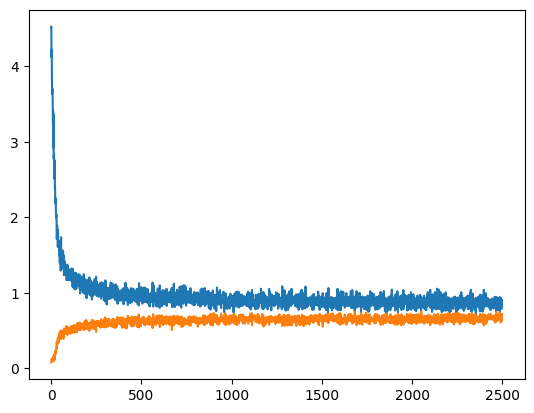

0.82937735
0.715


In [ ]:
# --------------- YOUR CODE HERE ---------------
x4,a4=train(torch_data1,labels1,net,net.fc.parameters())
ax=range(len(x4))
plt.plot(ax,x4,ax,a4)
plt.show()
print(x4[-1])
print(a4[-1])

**[ 5 points ]**

* Plot the loss vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

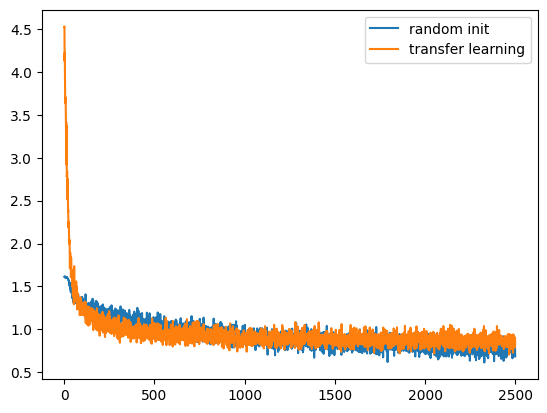

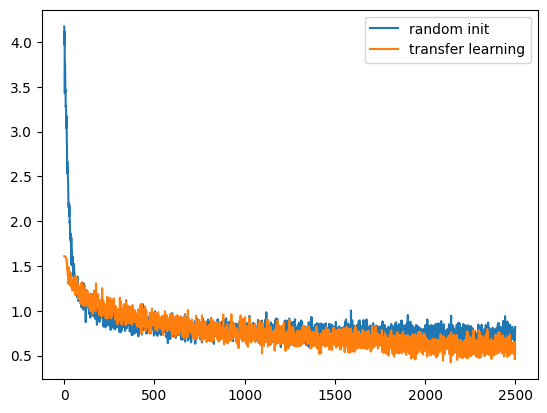

In [ ]:
ax=range(len(x1))
plt.plot(ax,x1,ax,x4)
plt.legend(['random init','transfer learning'])
plt.show()

ax=range(len(x2))
plt.plot(ax,x2,ax,x3)
plt.legend(['random init','transfer learning'])
plt.show()

Optional: Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this.